In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [3]:
base_dir = "Rice Leaf"

In [4]:
img_height = 299
img_width = 299
channels = 3
batch_size = 128

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,  
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

class_names = df.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in df:
    for label in labels.numpy():  
        class_counts[class_names[int(label)]] += 1  

print(class_counts)

Found 6265 files belonging to 6 classes.
{'blast': 1033, 'blight': 1063, 'brownspot': 1034, 'healthy': 1045, 'hispa': 1045, 'tungro': 1045}


In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Rescale image pixels
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Split 20% for validation
    fill_mode='nearest',
)

# No augmentation for validation and test datasets
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [7]:
train_ds = train_datagen.flow_from_directory(
  base_dir,
  subset="training",
  target_size=(img_height, img_width),
  batch_size=batch_size,
  seed=123,
  class_mode = "categorical"
  )
val_ds = val_test_datagen.flow_from_directory(
  base_dir,
  subset="validation",
  target_size=(img_height, img_width),
  seed=123,
  class_mode = "categorical")

Found 5014 images belonging to 6 classes.
Found 1251 images belonging to 6 classes.


In [8]:
data_dir = base_dir  
class_names = sorted(os.listdir(data_dir))
print(class_names)

['blast', 'blight', 'brownspot', 'healthy', 'hispa', 'tungro']


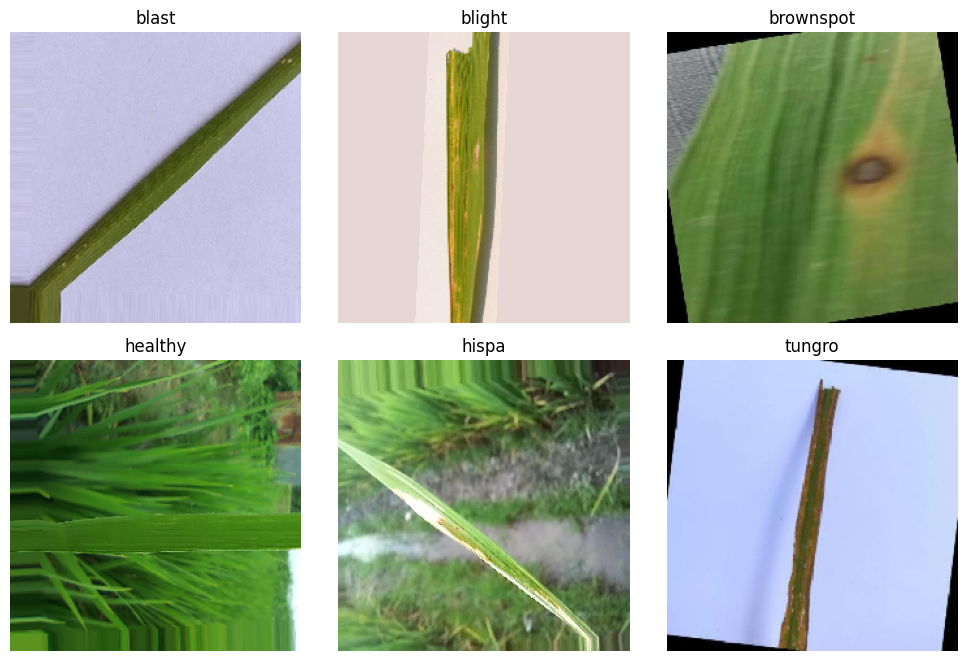

In [9]:
from tensorflow.keras.preprocessing import image
import random
class_names = os.listdir(data_dir)

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):  
        
        image_files = os.listdir(class_dir)
        
        if image_files:
           
            img_path = os.path.join(class_dir, random.choice(image_files))         
            img = image.load_img(img_path, target_size=(224, 224))
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

plt.tight_layout()
plt.show()

**Model Building**

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze semua lapisan base model
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Average pooling
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Regularization
predictions = Dense(6, activation='softmax')(x)
# Bangun model akhir
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self, patience=10):
        super(CustomCallback, self).__init__()
        self.patience = patience
        self.counter = 0
        self.best_val_acc = float('-inf')  
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.88 and logs['val_accuracy'] >= 0.88:
            self.model.stop_training = True
            print("\n Pelatihan berhenti karena akurasi dan val acc sudah 100%.")
        elif logs['val_accuracy'] > self.best_val_acc:
            self.best_val_acc = logs['val_accuracy']
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.model.stop_training = True
                print("\n Pelatihan berhenti karena val acc tidak meningkat dalam {} epoch terakhir.".format(self.patience))

callbacks = CustomCallback(patience=50)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [15]:
initial_epochs = 100
history = model.fit(train_ds,
                    callbacks = [callbacks, lr_scheduler],
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 295s 7s/step - accuracy: 0.7961 - loss: 0.6201 - val_accuracy: 0.8129 - val_loss: 0.5489 - learning_rate: 1.0000e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5355s 137s/step - accuracy: 0.8137 - loss: 0.5375 - val_accuracy: 0.8361 - val_loss: 0.4796 - learning_rate: 1.0000e-04
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 302s 8s/step - accuracy: 0.8332 - loss: 0.4906 - val_accuracy: 0.8497 - val_loss: 0.4507 - learning_rate: 1.0000e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 295s 7s/step - accuracy: 0.8469 - loss: 0.4483 - val_accuracy: 0.8489 - val_loss: 0.4270 - learning_rate: 1.0000e-04
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 301s 8s/step - accuracy: 0.8549 - loss: 0.4347 - val_accuracy: 0.8745 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.8624 - loss: 0.3981 - val_accuracy: 0.8817 - val_loss: 0.3758 - learning_rate: 1.0000e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accurac

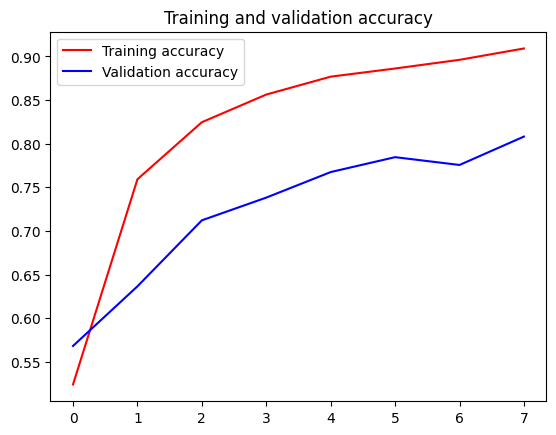

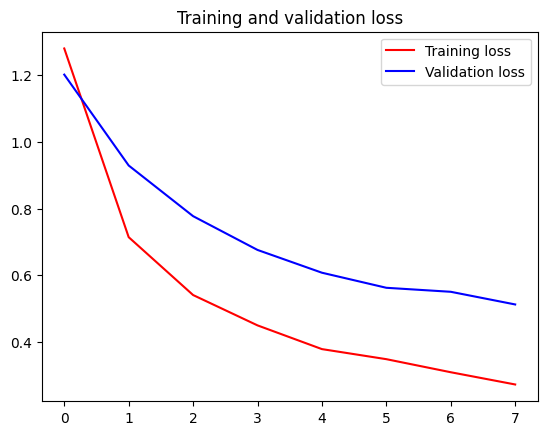

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
model.save('SmartPaddy_tf_.h5')  